Generate days: 100%|███████████████████████████████████████████████████████████████████| 32/32 [01:50<00:00,  3.47s/it]


<Figure size 432x288 with 0 Axes>

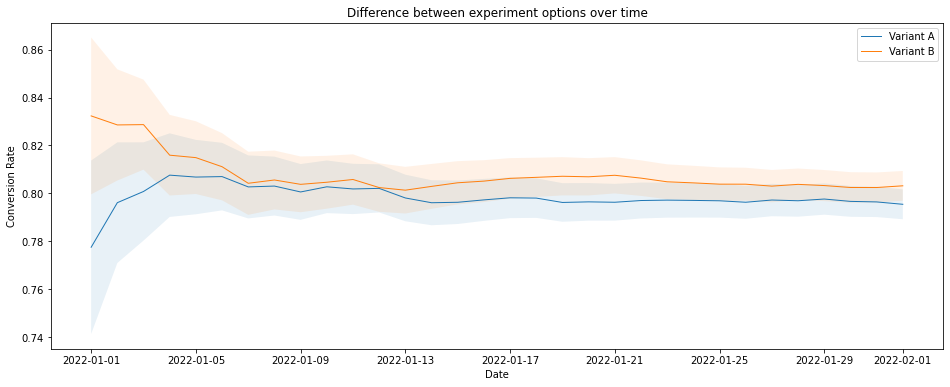

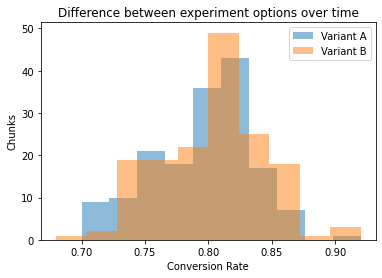

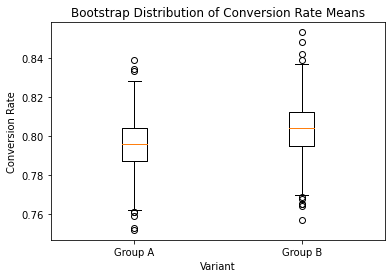

Control mean:  0.7954742715437074
Experimental mean:  0.8031867993450057
Difference in means:  0.0077125278012982745
95% Confidence interval of the difference in means:  [-0.027  0.046]


In [341]:
# import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import random, randint
from scipy import stats
import math
from tqdm import tqdm


# disabling chained assignment warning
pd.set_option("mode.chained_assignment", None)  # default='warn'

# set experiment parameters
experiment_start_at = '2022-01-01'
experiment_end_at = '2022-02-01'
users_per_day = 1000
users_per_day_variability = 10
variant_distribution = 50
convertion_rate = 80
started_user_id = randint(0, 10000)
confidence_level = 95 # to calculate the result

# function to calculate conversion rate and confidence interval
def calculate_ci(df):
    p = df.converted.sum() / df.user_id.count()
    n = len(df)
    z = stats.norm.ppf((1 + confidence_level / 100) / 2)
    ci = z * math.sqrt(p * (1 - p) / n)
    return {
        'conversion_rate': p,
        'ci_min': max(0, p - ci),
        'ci_max': min(1, p + ci)
        }

def bootstrap(control_values, experimental_values, n_bootstraps=1000, sample_size = 1000):
    control = np.zeros(n_bootstraps)
    experimental = np.zeros(n_bootstraps)
    
    for i in range(n_bootstraps):
        control[i] = np.mean(np.random.choice(control_values, size=sample_size))
        experimental[i] = np.mean(np.random.choice(experimental_values, size=sample_size))
    ci = np.percentile(experimental - control, [2.5, 97.5])
    return {
        'control': control,
        'experimental': experimental,
        'ci': ci
        }

# initialize first user_id and the experiment dataframe
boofer_user_id = started_user_id
experiment_df = pd.DataFrame(columns=['date', 'variant', 'user_id', 'converted'])

# generate experiment data
for day in tqdm(pd.date_range(experiment_start_at,  experiment_end_at, freq='D'), desc='Generate days'):
    for user in range(0, randint(users_per_day - users_per_day_variability, users_per_day + users_per_day_variability)):
        experiment_df = experiment_df.append(pd.DataFrame({
            "date": [day.date()],
            "variant": ['A' if random() < variant_distribution/100 else 'B'],
            "user_id": [boofer_user_id],
            "converted": [True if random() < convertion_rate/100 else False]
        }))
        boofer_user_id += 1
        

# initialize plot dataframe
plot_df = pd.DataFrame(columns=['date', 'variant', 'conversion_rate', 'ci_min', 'ci_max'])

# calculate cummulative conversion rate and confidence interval
for date in experiment_df.sort_values(by='date', ascending=True).date.unique():
    boofer_df = experiment_df[experiment_df.date <= date]
    boofer_df['date'] = date
    
    for variant in boofer_df.variant.unique():
        ci = calculate_ci(boofer_df[boofer_df.variant == variant])
        plot_df = plot_df.append(pd.DataFrame({
        "date": [date],
        "variant": [variant],
        "conversion_rate": [ci['conversion_rate']],
        "ci_min": [max(0, ci['ci_min'])],
        "ci_max": [min(1, ci['ci_max'])]
        }))

# plot results
plt.figure()
plt.figure(figsize=(16,6))
for variant in plot_df.variant.unique():
    plt.plot(plot_df[plot_df.variant == variant].date, plot_df[plot_df.variant == variant].conversion_rate, label=f'Variant {variant}', linewidth=1)
    plt.fill_between(plot_df[plot_df.variant == variant].date, plot_df[plot_df.variant == variant].ci_min, plot_df[plot_df.variant == variant].ci_max, alpha=0.1)
plt.title("Difference between experiment options over time")
plt.xlabel("Date")
plt.ylabel("Conversion Rate")
plt.legend()
plt.show()

control_data = experiment_df[experiment_df.variant == 'A'].converted.astype('float64')
experimental_data = experiment_df[experiment_df.variant == 'B'].converted.astype('float64')

# Visualizing the data
hist_df = pd.DataFrame(columns=['variant', 'conversion'])
chunk = 100
for variant in experiment_df.variant.unique():
    df = experiment_df[experiment_df.variant == variant].sort_values(by='user_id', ascending=True).reset_index(drop=True)
    for i in range(0, len(df), chunk):
        hist_df = hist_df.append(pd.DataFrame({
            'variant': [variant],
            'conversion': [df[i:i+chunk].converted.mean()]
            }))
plt.hist(hist_df[hist_df.variant == 'A'].conversion, bins=int(chunk/10), alpha=0.5, label='Variant A')
plt.hist(hist_df[hist_df.variant == 'B'].conversion, bins=int(chunk/10), alpha=0.5, label='Variant B')
plt.title("Difference between experiment options over time")
plt.xlabel("Conversion Rate")
plt.ylabel("Frequency")
plt.legend()
plt.show()


bs = bootstrap(control_data, experimental_data)
plt.boxplot([bs['control'], bs['experimental']], vert=True)
plt.xlabel("Variant")
plt.ylabel("Conversion Rate")
plt.title("Bootstrap Distribution of Conversion Rate Means")
plt.xticks([1, 2], ['Group A', 'Group B'])
plt.show()
print("Control mean: ", np.mean(control_data))
print("Experimental mean: ", np.mean(experimental_data))
print("Difference in means: ", np.mean(experimental_data) - np.mean(control_data))
print("95% Confidence interval of the difference in means: ", bs['ci'])

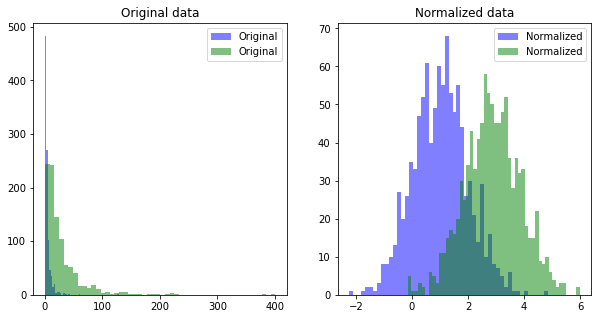

p-value: 0.0320
Reject Null Hypothesis: There is significant difference between the means of variant A and B


In [343]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm

np.random.seed(42)

# Generating A/B test data with log-normal distribution

data_A = lognorm.rvs(s=1, loc=0, scale=np.exp(1), size=1000)
data_B = lognorm.rvs(s=1, loc=0, scale=np.exp(2.8), size=1000)

# Normalizing data

data_A_normalized = np.log(data_A)
data_B_normalized = np.log(data_B)

# Plotting histograms of original and normalized data

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1.hist(data_A, bins=50, color='blue', alpha=0.5, label='Original')
ax1.hist(data_B, bins=50, color='green', alpha=0.5, label='Original')
ax1.set_title('Original data')
ax1.legend()

ax2.hist(data_A_normalized, bins=50, color='blue', alpha=0.5, label='Normalized')
ax2.hist(data_B_normalized, bins=50, color='green', alpha=0.5, label='Normalized')
ax2.set_title('Normalized data')
ax2.legend()

plt.show()

# Computing and printing p-value for A/B test

p_value = norm.cdf(np.mean(data_A_normalized) - np.mean(data_B_normalized))
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject Null Hypothesis: There is significant difference between the means of variant A and B")
else:
    print("Fail to reject Null Hypothesis: There is no significant difference between the means of variant A and B")